# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.734861,True,5.677652
1,1.692967,True,5.345768
2,-0.678012,True,5.865227
3,0.320417,False,-1.465444
4,-1.743889,True,5.025204
...,...,...,...
995,-1.195709,False,-0.097315
996,1.086976,False,1.035984
997,0.115227,True,4.093856
998,0.986937,True,4.631330


<Axes: xlabel='v0'>

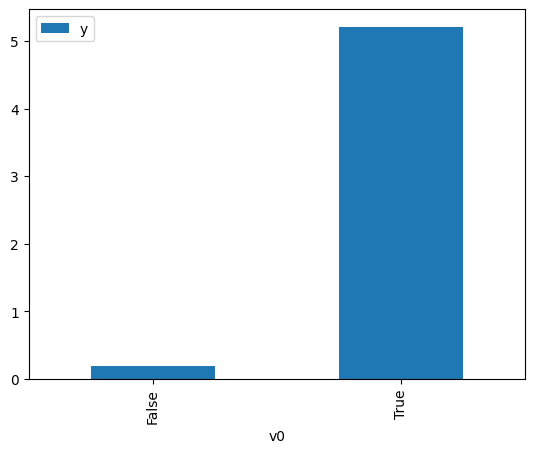

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

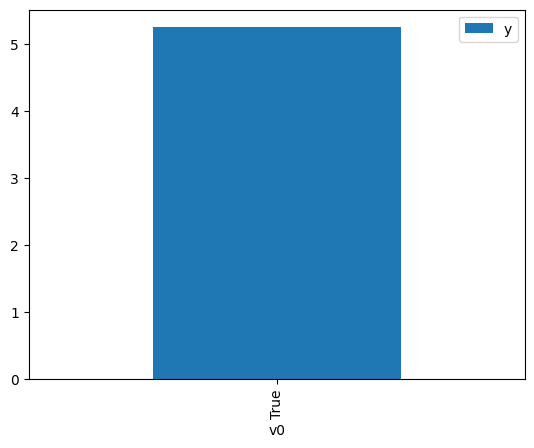

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.425122,False,1.553599,0.468980,2.132286
1,1.522968,False,2.940058,0.464910,2.150952
2,1.624560,False,-0.714125,0.460690,2.170659
3,1.883998,False,-1.628021,0.449938,2.222528
4,0.781901,False,-1.317539,0.495812,2.016892
...,...,...,...,...,...
995,1.883998,False,-1.628021,0.449938,2.222528
996,1.624560,False,-0.714125,0.460690,2.170659
997,0.027170,False,1.790618,0.527316,1.896398
998,0.538403,False,-1.014590,0.505985,1.976345


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.628855,True,5.879210,0.539489,1.853607
1,0.800083,True,5.501920,0.504947,1.980405
2,1.329587,True,6.044962,0.527042,1.897382
3,2.467841,True,2.798915,0.574072,1.741940
4,0.387281,True,3.828899,0.487704,2.050424
...,...,...,...,...,...
995,2.490357,True,6.209058,0.574992,1.739154
996,0.802514,True,5.794019,0.505049,1.980007
997,0.835262,True,4.489131,0.506417,1.974659
998,0.080196,True,4.995161,0.474894,2.105735


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              7086.
Date:                Sat, 12 Jul 2025   Prob (F-statistic):                        0.00
Time:                        13:59:10   Log-Likelihood:                         -1425.1
No. Observations:                1000   AIC:                                      2854.
Df Residuals:                     998   BIC:                                      2864.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2809      0.028      9.906      0.000       0.225       0.337
x2             5.0450      0.052     97.125      0.000       4.943       5.147
==============================================================================
Omnibus:                        1.607   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.600
Skew:                           0.047   Prob(JB):                        0.449
Kurtosis:                       2.828   Cond. No.                         2.33
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""